In [ ]:
import sys
import gym
import collections
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [1]:
class Network(nn.Module):
    def __init__(self, input_shape, action_space, fc1_dim, fc2_dim):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(*input_shape, fc1_dim)
        self.fc2 = nn.Linear(fc1_dim, fc2_dim)
        self.fc3 = nn.Linear(fc2_dim, action_space)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ReplayBuffer:
    def __init__(self, obs_dim, size, batch_size):
        self.memory_size, self.batch_size = size, batch_size
        self.mem_idx, self.size, = 0, 0
        
        self.obs = np.zeros([size, obs_dim], dtype = np.float32)
        self.acts = np.zeros([size], dtype = np.float32)
        self.rewards = np.zeros([size], dtype = np.float32)
        self.obs_ = np.zeros([size, obs_dim], dtype = np.float32)
        self.dones = np.zeros(size, dtype = np.float32)

    def add(self, obs, acts, rewards, obs_, dones):
        self.mem_idx = self.mem_idx % self.memory_size
        
        self.obs[self.mem_idx] = obs
        self.obs_[self.mem_idx] = obs_
        self.acts[self.mem_idx] = acts
        self.rewards[self.mem_idx] = rewards
        self.dones[self.mem_idx] = dones
       
        self.size = min(self.size + 1, self.memory_size)

    def sample(self):
        i = np.random.choice(self.size, size = self.batch_size, replace = False)
        out = dict(obs = self.obs[i], obs_ = self.obs_[i], acts = self.acts[i], rewards = self.rewards[i], dones = self.dones[i])
        return out

    def __len__(self):
        return int(self.size)
    
class DQN_Solver:
    def __init__(self, model, target_model, replay_buffer, learning_rate): 
        self.model = model
        self.target_model = target_model
        self.replay_buffer = replay_buffer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = learning_rate)
    
    def choose_action(self, obs, epsilon):
        if random.random() < epsilon:
            return random.randint(0, 1)
        else:
            return self.model.forward(obs).argmax().item()
        
    def train(self, batch_size, learning_rate, gamma): 
        samples = self.replay_buffer.sample()
        
        states = torch.FloatTensor(samples["obs"])
        actions = torch.LongTensor(samples["acts"].reshape(-1, 1))
        rewards = torch.FloatTensor(samples["rewards"].reshape(-1, 1))
        states_ = torch.FloatTensor(samples["obs_"])
        dones = torch.FloatTensor(samples["dones"].reshape(-1,1))
        
        q_target_max = self.target_model(states_).max(1)[0].unsqueeze(1).detach()
        target = rewards + gamma * q_target_max * dones
        q_out = self.model(states)
        q_a = q_out.gather(1, actions)
        
        loss = F.smooth_l1_loss(q_a, target)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
def main(): 
    np.random.seed(1)
    env = gym.make("CartPole-v1")
    
    episodes = 1000
    batch_size = 64
    learning_rate = 0.001
    buffer_len = 100000
    
    print_per_i = 100
    target_update_period = 4
    
    eps_start = 1
    eps_end = 0.001
    eps_decay = 0.995
    tau = 1*1e-2
    max_step = 2000
    gamma = 0.99

    input_shape = env.observation_space.shape
    action_space = env.action_space.n
    fc1_dim = 1024
    fc2_dim = 512
    
    Q = Network(input_shape, action_space, fc1_dim, fc2_dim)
    Q_target = Network(input_shape, action_space, fc1_dim, fc2_dim)
    Q_target.load_state_dict(Q.state_dict())

    replay_buffer = ReplayBuffer(input_shape[0], size = buffer_len, batch_size = batch_size)

    score = 0
    score_sum = 0
    best_reward = 0
    epsilon = eps_start

    for i in range(episodes):
        s = env.reset()
        done = False
        for t in range(max_step):
            a = DQN_Solver(Q, Q_target, replay_buffer, learning_rate).choose_action(obs = torch.from_numpy(s).float(), epsilon = epsilon)
            s_prime, r, done, _ = env.step(a)
            done_mask = 0.0 if done else 1.0
            replay_buffer.add(s, a, r/100.0, s_prime, done_mask)
            s = s_prime
            
            score += r
            score_sum += r

            if len(replay_buffer) >= batch_size:
                DQN_Solver(Q, Q_target, replay_buffer, learning_rate).train(batch_size, learning_rate, gamma)
                
                if score > best_reward:
                    best_reward = score
                
                if (t + 1) % target_update_period == 0:
                    for target_param, local_param in zip(Q_target.parameters(), Q.parameters()):
                        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)    
            if done:
                break
        epsilon = max(eps_end, epsilon * eps_decay)

        if i % print_per_i == 0 and i!=0:
            print("Episode: {}, Average Reward: {:.2f}, Epsilon : {:.2f}".format(i, score_sum/print_per_i, epsilon))
            score_sum = 0.0
        score = 0
        
    env.close()

NameError: name 'nn' is not defined

In [ ]:
main()

In [4]:
class Network(nn.Module):
    def __init__(self, state_space, action_space, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        self.fc1 = nn.Linear(state_space, self.hidden_dim)
        self.lstm = nn.LSTM(self.hidden_dim, self.hidden_dim, batch_first = True)
        self.fc2 = nn.Linear(self.hidden_dim, action_space)

    def forward(self, x, h, c):
        x = F.relu(self.fc1(x))
        x, (new_h, new_c) = self.lstm(x, (h, c))
        x = self.fc2(x)
        return x, new_h, new_c
    
    def init_hidden_state(self, batch_size, training):
        if training is True:
            h, c = torch.zeros([1, batch_size, self.hidden_dim]), torch.zeros([1, batch_size, self.hidden_dim])
        else:
            h, c = torch.zeros([1, 1, self.hidden_dim]), torch.zeros([1, 1, self.hidden_dim])
        return h, c
    
class EpisodeMemory:
    def __init__(self, lookup_step = 20, random_update = False, max_eps_num = 100, max_eps_len = 500, batch_size = 1):
        self.random_update = random_update
        self.max_eps_num = max_eps_num
        self.max_eps_len = max_eps_len
        self.batch_size = batch_size
        self.lookup_step = lookup_step
        self.memory = collections.deque(maxlen = self.max_eps_num)

    def add(self, episode):
        self.memory.append(episode)

    def sample(self):
        sampled_buffer = []
        
        if self.random_update: 
            sampled_episodes = random.sample(self.memory, self.batch_size)
            min_step = self.max_eps_len
            for episode in sampled_episodes:
                min_step = min(min_step, len(episode)) 

            for episode in sampled_episodes:
                if min_step > self.lookup_step: 
                    i = np.random.randint(0, len(episode) - self.lookup_step + 1)
                    sample = episode.sample(random_update = self.random_update, lookup_step = self.lookup_step, i = i)
                else:
                    i = np.random.randint(0, len(episode) - min_step + 1) 
                    sample = episode.sample(random_update = self.random_update, lookup_step = min_step, i = i)
                sampled_buffer.append(sample)
        else:
            i = np.random.randint(0, len(self.memory))
            sampled_buffer.append(self.memory[idx].sample(random_update = self.random_update))
        return sampled_buffer, len(sampled_buffer[0]['obs'])

    def __len__(self):
        return len(self.memory)

class EpisodeBuffer:
    def __init__(self):
        self.obs = []
        self.actions = []
        self.rewards = []
        self.obs_ = []
        self.dones = []

    def add(self, new_eps):
        self.obs.append(new_eps[0])
        self.actions.append(new_eps[1])
        self.rewards.append(new_eps[2])
        self.obs_.append(new_eps[3])
        self.dones.append(new_eps[4])

    def sample(self, lookup_step, i, random_update = False,): 
        obs = np.array(self.obs)
        actions = np.array(self.actions)
        rewards = np.array(self.rewards)
        obs_ = np.array(self.obs_)
        dones = np.array(self.dones)

        if random_update is True:
            obs = obs[i:i+lookup_step]
            actions = actions[i:i+lookup_step]
            rewards = rewards[i:i+lookup_step]
            obs_ = obs_[i:i+lookup_step]
            dones = dones[i:i+lookup_step]
        
        out = dict(obs = obs, actions = actions, rewards = rewards, obs_ = obs_, dones = dones)
        return out

    def __len__(self):
        return int(len(self.obs))

class DQN_Solver: 
    def __init__(self, model, target_model, learning_rate): 
        self.model = model
        self.target_model = target_model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = learning_rate)
    
    def choose_action(self, obs, h, c, epsilon):
        output = self.model.forward(obs, h, c)
        if random.random() < epsilon:
            return random.randint(0,1), output[1], output[2]
        else:
            return output[0].argmax().item(), output[1] , output[2]
    
    def train(self, q_net, target_q_net, episode_memory, batch_size=1, learning_rate=1e-3, gamma=0.99):
        samples, seq_len = episode_memory.sample()
        obs, actions, rewards, obs_, dones = [], [], [], [], []
        
        for i in range(batch_size):
            obs.append(samples[i]["obs"])
            actions.append(samples[i]["actions"])
            rewards.append(samples[i]["rewards"])
            obs_.append(samples[i]["obs_"])
            dones.append(samples[i]["dones"])

        obs = np.array(obs)
        actions = np.array(actions)
        rewards = np.array(rewards)
        obs_ = np.array(obs_)
        dones = np.array(dones)

        obs = torch.FloatTensor(obs.reshape(batch_size, seq_len, -1))
        actions = torch.LongTensor(actions.reshape(batch_size, seq_len, -1))
        rewards = torch.FloatTensor(rewards.reshape(batch_size, seq_len, -1))
        obs_ = torch.FloatTensor(obs_.reshape(batch_size, seq_len, -1))
        dones = torch.FloatTensor(dones.reshape(batch_size, seq_len, -1))

        h_target, c_target = self.target_model.init_hidden_state(batch_size = batch_size, training = True)
        q_target, _, _ = self.target_model(obs_, h_target, c_target)
        q_target_max = q_target.max(2)[0].view(batch_size,seq_len,-1).detach()
        targets = rewards + gamma * q_target_max * dones

        h, c = self.model.init_hidden_state(batch_size = batch_size, training = True)
        q_out, _, _ = self.model(obs, h, c)
        q_a = q_out.gather(2, actions)
   
        loss = F.smooth_l1_loss(q_a, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

def main(): 
    env = gym.make("CartPole-v1")
    np.random.seed(1)
   
    batch_size = 8
    learning_rate = 0.001
    buffer_len = 100000
    min_eps_num = 20 #start training Q network
    episodes = 10000
    print_per_iter = 100
    target_update_period = 4
    eps_start = 0.1
    eps_end = 0.001
    eps_decay = 0.995
    tau = 0.001
    max_step = 500
    gamma = 0.99

    random_update = True
    lookup_step = 20 
    max_eps_len = 100 

    state_space = env.observation_space.shape[0]-2
    action_space = env.action_space.n
    hidden_dim = 64
    
    Q = Network(state_space, action_space, hidden_dim)
    Q_target = Network(state_space, action_space, hidden_dim)
    Q_target.load_state_dict(Q.state_dict())

    score = 0
    score_sum = 0
    epsilon = eps_start
    
    episode_memory = EpisodeMemory(random_update = random_update, max_eps_num = 100, max_eps_len = 600, batch_size = batch_size, lookup_step = lookup_step)
    
    eps = []
    rewards = []
    avg_rewards = []

    for i in range(1, episodes):
        s = env.reset()
        obs = s[::2] #use only positions of cart & pole
        done = False
        episode_record = EpisodeBuffer()
        h, c = Q.init_hidden_state(batch_size = batch_size, training = False)
        
        eps.append(i)

        for t in range(max_step):
            a, h, c = DQN_Solver(Q, Q_target, learning_rate).choose_action(torch.from_numpy(obs).float().unsqueeze(0).unsqueeze(0), h, c, epsilon)
            s_prime, r, done, _ = env.step(a)
            obs_prime = s_prime[::2]

            done_mask = 0 if done else 1
            episode_record.add([obs, a, r/100.0, obs_prime, done_mask])
            obs = obs_prime
            
            score += r
            score_sum += r

            if len(episode_memory) >= min_eps_num:
                DQN_Solver(Q, Q_target, learning_rate).train(Q, Q_target, episode_memory, batch_size=batch_size, learning_rate=learning_rate, gamma = gamma)
                if t % target_update_period == 0:
                    for target_param, local_param in zip(Q_target.parameters(), Q.parameters()): # <- soft update
                            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)
            if done: break
        episode_memory.add(episode_record)
        
        epsilon = max(eps_end, epsilon * eps_decay)
        
        rewards.append(score)
        avg_rewards.append(np.mean(rewards))
        if i % print_per_iter == 0:
            print("Episode: {}, Score: {:.3f}, Epsilon: {:.3f}".format(i, score_sum/i, epsilon))
        score = 0
    
    env.close()
    
    plt.plot(eps, rewards)
    plt.plot(eps, avg_rewards, color = 'g')
    plt.show()

Episode: 100, Score: 25.490, Epsilon: 0.061
Episode: 200, Score: 22.850, Epsilon: 0.037
Episode: 300, Score: 21.647, Epsilon: 0.022
Episode: 400, Score: 21.328, Epsilon: 0.013
Episode: 500, Score: 20.312, Epsilon: 0.008
Episode: 600, Score: 19.562, Epsilon: 0.005
Episode: 700, Score: 19.037, Epsilon: 0.003
Episode: 800, Score: 19.073, Epsilon: 0.002
Episode: 900, Score: 19.241, Epsilon: 0.001
Episode: 1000, Score: 19.128, Epsilon: 0.001
Episode: 1100, Score: 19.924, Epsilon: 0.001
Episode: 1200, Score: 20.538, Epsilon: 0.001
Episode: 1300, Score: 21.243, Epsilon: 0.001
Episode: 1400, Score: 22.517, Epsilon: 0.001
Episode: 1500, Score: 23.175, Epsilon: 0.001
Episode: 1600, Score: 23.323, Epsilon: 0.001
Episode: 1700, Score: 23.408, Epsilon: 0.001
Episode: 1800, Score: 24.384, Epsilon: 0.001
Episode: 1900, Score: 25.606, Epsilon: 0.001
Episode: 2000, Score: 26.396, Epsilon: 0.001
Episode: 2100, Score: 26.400, Epsilon: 0.001
Episode: 2200, Score: 26.248, Epsilon: 0.001
Episode: 2300, Scor

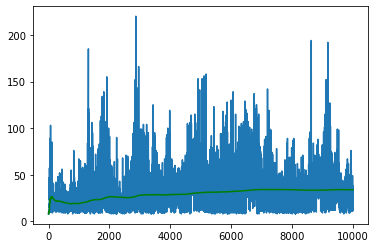

In [5]:
main()